## Importing all required python libraries

In [27]:
import pyspark
import pandas as pd
import numpy as np
import graphviz

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score

from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

### Loading the dataset

In [40]:
fraud_data = pd.read_csv('F:/Fraud Transaction python/Fraud.csv', sep = ',')

In [41]:
# Preview the dataset

fraud_data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [50]:
# Lets correct the column name thier data types 

fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


### 1. Data cleaning including missing values, outliers and multi-collinearity.

In [51]:
fraud_data.isnull().sum().sort_values(ascending = False)

isFlaggedFraud    0
isFraud           0
newbalanceDest    0
oldbalanceDest    0
nameDest          0
newbalanceOrig    0
oldbalanceOrg     0
nameOrig          0
amount            0
type              0
step              0
dtype: int64

In [81]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Exploratory Data Analysis

After this we will get the answer of the following quetion:

### 2. How did you select variables to be included in the model?

Lets check number of fraud transaction and thier types

In [57]:
print('\n The types of fraudulent transactions are {}'.format(\
list(fraud_data.loc[fraud_data.isFraud == 1].type.drop_duplicates().values))) # only 'CASH_OUT' 
                                                             # & 'TRANSFER'

Fraud_Transfer = fraud_data.loc[(fraud_data.isFraud == 1) & (fraud_data.type == 'TRANSFER')]
Fraud_Cashout = fraud_data.loc[(fraud_data.isFraud == 1) & (fraud_data.type == 'CASH_OUT')]

print ('\n The number of fraudulent TRANSFERs = {}'.\
       format(len(Fraud_Transfer))) # 4097

print ('\n The number of fraudulent CASH_OUTs = {}'.\
       format(len(Fraud_Cashout))) # 4116


 The types of fraudulent transactions are ['TRANSFER', 'CASH_OUT']

 The number of fraudulent TRANSFERs = 4097

 The number of fraudulent CASH_OUTs = 4116


#### There are fraud in only Two types of transfers that are Transfer and Cashout ie. 4097 and 4116 frauds respectively

In [60]:
print('\nThe type of transactions in which isFlaggedFraud is set: \
{}'.format(list(fraud_data.loc[fraud_data.isFlaggedFraud == 1].type.drop_duplicates()))) 
                                                            # only 'TRANSFER'

dfTransfer = fraud_data.loc[fraud_data.type == 'TRANSFER']
fraud_Flagged = fraud_data.loc[fraud_data.isFlaggedFraud == 1]
fraud_NotFlagged = fraud_data.loc[fraud_data.isFlaggedFraud == 0]

print('\nMin amount transacted when isFlaggedFraud is set= {}'\
                                  .format(fraud_Flagged.amount.min())) # 353874.22

print('\nMax amount transacted in a TRANSFER where isFlaggedFraud is not set=\
 {}'.format(dfTransfer.loc[dfTransfer.isFlaggedFraud == 0].amount.max())) # 92445516.64


The type of transactions in which isFlaggedFraud is set: ['TRANSFER']

Min amount transacted when isFlaggedFraud is set= 353874.22

Max amount transacted in a TRANSFER where isFlaggedFraud is not set= 92445516.64


In [65]:
print('\nMin, Max of oldBalanceOrig for isFlaggedFraud = 1 TRANSFERs: {}'.\
format([round(fraud_Flagged.oldbalanceOrg.min()), round(fraud_Flagged.oldbalanceOrg.max())]))

print('\nMin, Max of oldBalanceOrig for isFlaggedFraud = 0 TRANSFERs where \
oldBalanceOrig = \
newBalanceOrig: {}'.format(\
[dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldbalanceOrg \
== dfTransfer.newbalanceOrig)].oldbalanceOrg.min(), \
round(dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldbalanceOrg \
               == dfTransfer.newbalanceOrig)].oldbalanceOrg.max())]))


Min, Max of oldBalanceOrig for isFlaggedFraud = 1 TRANSFERs: [353874, 19585040]

Min, Max of oldBalanceOrig for isFlaggedFraud = 0 TRANSFERs where oldBalanceOrig = newBalanceOrig: [0.0, 575668]


In [66]:
print('\nHave originators of transactions flagged as fraud transacted more than \
once? {}'\
.format((fraud_Flagged.nameOrig.isin(pd.concat([fraud_NotFlagged.nameOrig, \
                                    fraud_NotFlagged.nameDest]))).any())) 

print('\nHave destinations for transactions flagged as fraud initiated\
 other transactions? \
{}'.format((fraud_Flagged.nameDest.isin(fraud_NotFlagged.nameOrig)).any())) 

# Only 2 destination accounts of 16 that have 'isFlaggedFraud' set have been destination accounts more than once,
# clearly 'isFlaggedFraud' being set is independent of whether a destination account has been used before or not

print('\nHow many destination accounts of transactions flagged as fraud have been \
destination accounts more than once?: {}'\
.format(sum(fraud_Flagged.nameDest.isin(fraud_NotFlagged.nameDest)))) # 2


Have originators of transactions flagged as fraud transacted more than once? False

Have destinations for transactions flagged as fraud initiated other transactions? False

How many destination accounts of transactions flagged as fraud have been destination accounts more than once?: 2


#### isFlaggedFraud is set just 16 times in a seemingly meaningless way, we may not need this column as it is not significant for our analysis

In [67]:
print('\nAre there any merchants among originator accounts for CASH_IN \
transactions? {}'.format(\
(fraud_data.loc[fraud_data.type == 'CASH_IN'].nameOrig.str.contains('M')).any())) 


Are there any merchants among originator accounts for CASH_IN transactions? False


In [68]:
print('\nAre there any merchants among destination accounts for CASH_OUT \
transactions? {}'.format(\
(fraud_data.loc[fraud_data.type == 'CASH_OUT'].nameDest.str.contains('M')).any())) 


Are there any merchants among destination accounts for CASH_OUT transactions? False


In [70]:
print('\nAre there merchants among any originator accounts? {}'.format(\
      fraud_data.nameOrig.str.contains('M').any())) 

print('\nAre there any transactions having merchants among destination accounts\
 other than the PAYMENT type? {}'.format(\
(fraud_data.loc[fraud_data.nameDest.str.contains('M')].type != 'PAYMENT').any()))


Are there merchants among any originator accounts? False

Are there any transactions having merchants among destination accounts other than the PAYMENT type? False


## Conclusion: 

##### Among the account labels nameOrig and nameDest, for all transactions, the merchant prefix of 'M' occurs in an unexpected way.

Assemble only the corresponding data in X for analysis as we know that fraud occurs only in Transfer and cashout

In [71]:
X = fraud_data.loc[(fraud_data.type == 'TRANSFER') | (fraud_data.type == 'CASH_OUT')]

randomState = 5
np.random.seed(randomState)

Y = X['isFraud']
del X['isFraud']

# Eliminate columns shown to be irrelevant for analysis in the EDA
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

# Binary-encoding of labelled data in 'type'
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int) # convert dtype('O') to dtype(int)

The data has several transactions with zero balances in the destination account both before and after a non-zero amount is transacted. The fraction of such transactions, where zero likely denotes a missing value, is much larger in fraudulent (50%) compared to genuine transactions (0.06%).

In [72]:
Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]
print('\nThe fraction of fraudulent transactions with \'oldBalanceDest\' = \
\'newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(Xfraud.loc[(Xfraud.oldbalanceDest == 0) & \
(Xfraud.newbalanceDest == 0) & (Xfraud.amount)]) / (1.0 * len(Xfraud))))

print('\nThe fraction of genuine transactions with \'oldBalanceDest\' = \
newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(XnonFraud.loc[(XnonFraud.oldbalanceDest == 0) & \
(XnonFraud.newbalanceDest == 0) & (XnonFraud.amount)]) / (1.0 * len(XnonFraud))))


The fraction of fraudulent transactions with 'oldBalanceDest' = 'newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.4955558261293072

The fraction of genuine transactions with 'oldBalanceDest' = newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.0006176245277308345


Instead, below we replace the value of 0 with -1 which will be more useful to a suitable machine-learning (ML) algorithm detecting fraud.

In [73]:
X.loc[(X.oldbalanceDest == 0) & (X.newbalanceDest == 0) & (X.amount != 0), \
      ['oldbalanceDest', 'newbalanceDest']] = - 1

In [74]:
X.loc[(X.oldbalanceOrg == 0) & (X.newbalanceOrig == 0) & (X.amount != 0), \
      ['oldbalanceOrg', 'newbalanceOrig']] = np.nan

These new features turn out to be important in obtaining the best performance from the ML algorithm that we will finally use.

In [75]:
X['errorBalanceOrig'] = X.newbalanceOrig + X.amount - X.oldbalanceOrg
X['errorBalanceDest'] = X.oldbalanceDest + X.amount - X.newbalanceDest

## Data visualization

Lets check if there are any outlier that can affect our analysis

In [76]:
limit = len(X)

def plotStrip(x, y, hue, figsize = (14, 9)):
    
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(0, 1, 9))
    with sns.axes_style('ticks'):
        ax = sns.stripplot(x, y, \
             hue = hue, jitter = 0.4, marker = '.', \
             size = 4, palette = colours)
        ax.set_xlabel('')
        ax.set_xticklabels(['genuine', 'fraudulent'], size = 16)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1), \
               loc=2, borderaxespad=0, fontsize = 16);
    return ax

E:\Anaconda12\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


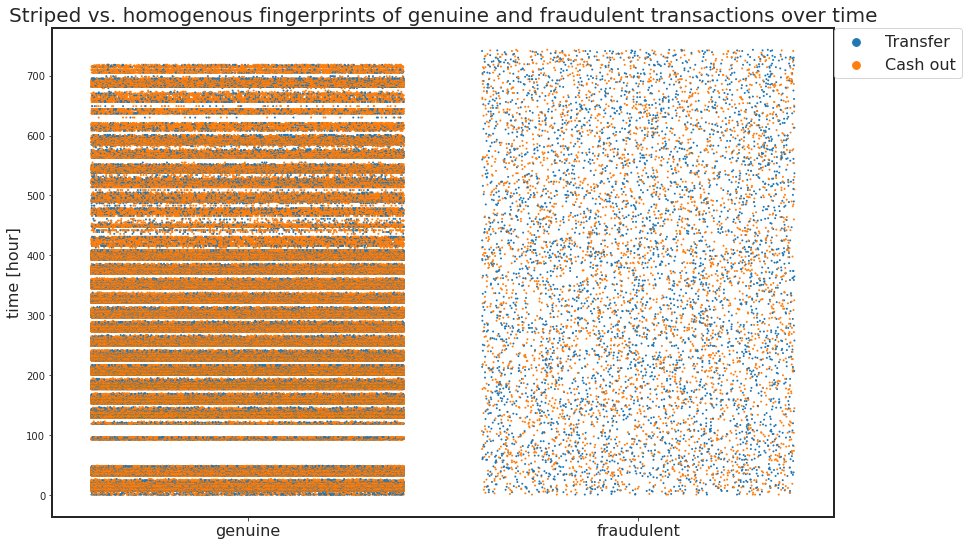

In [79]:
ax = plotStrip(Y[:limit], X.step[:limit], X.type[:limit])
ax.set_ylabel('time [hour]', size = 16)
ax.set_title('Striped vs. homogenous fingerprints of genuine and fraudulent \
transactions over time', size = 20);

The two plots below shows that although the presence of fraud in a transaction can be discerned by the original amount feature, the new errorBalanceDest feature is more effective at making a distinction

E:\Anaconda12\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


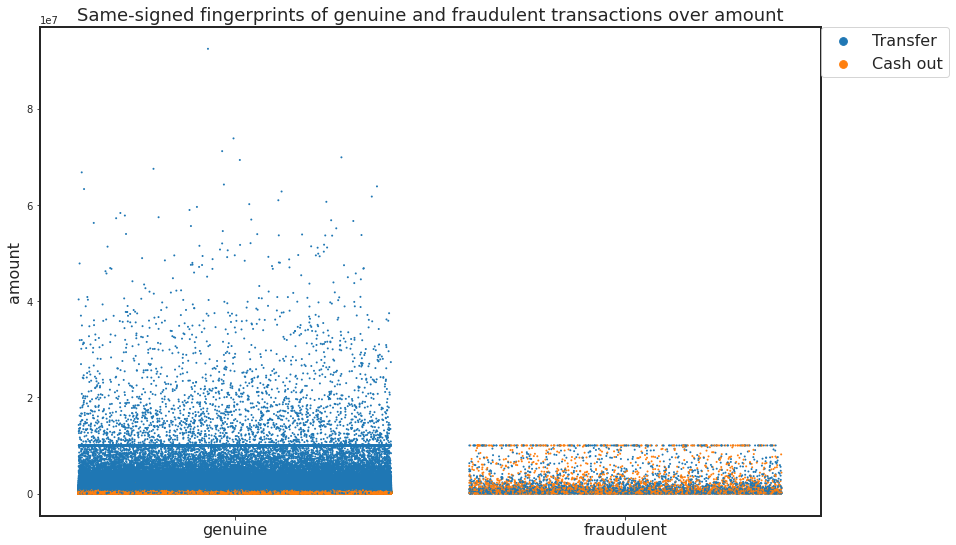

In [80]:
limit = len(X)
ax = plotStrip(Y[:limit], X.amount[:limit], X.type[:limit], figsize = (14, 9))
ax.set_ylabel('amount', size = 16)
ax.set_title('Same-signed fingerprints of genuine \
and fraudulent transactions over amount', size = 18);

Dispersion over error in balance in destination accounts

E:\Anaconda12\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


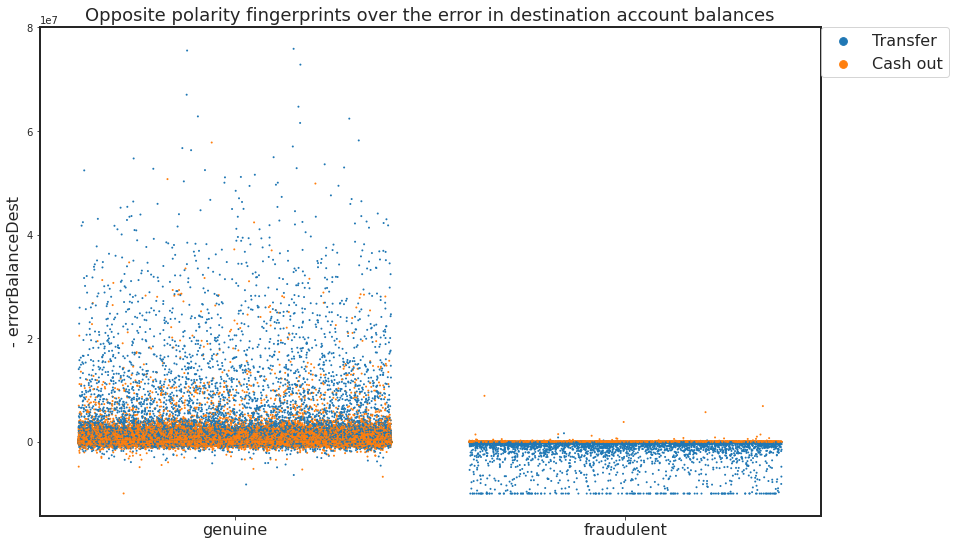

In [82]:
limit = len(X)
ax = plotStrip(Y[:limit], - X.errorBalanceDest[:limit], X.type[:limit], \
              figsize = (14, 9))
ax.set_ylabel('- errorBalanceDest', size = 16)
ax.set_title('Opposite polarity fingerprints over the error in \
destination account balances', size = 18);

Separating out genuine from fraudulent transactions

The 3D plot below distinguishes best between fraud and non-fraud data by using both of the engineered error-based features. Clearly, the original step feature is ineffective in seperating out fraud


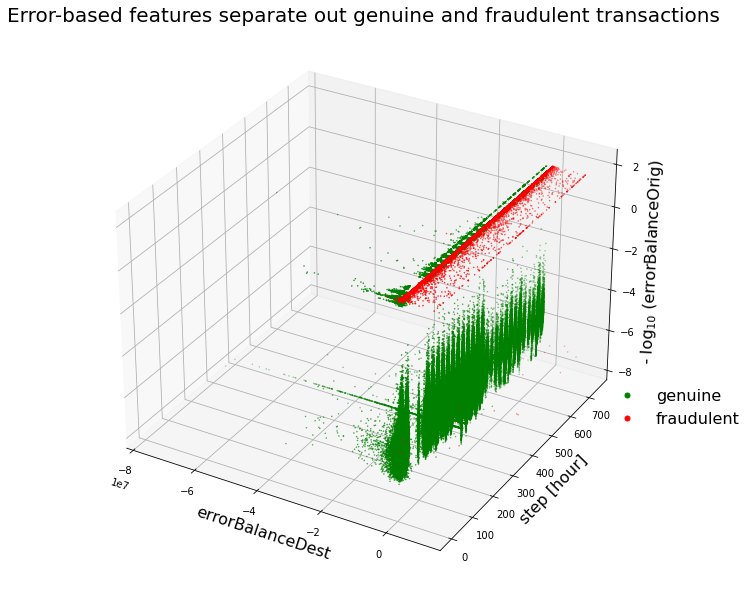

In [83]:
x = 'errorBalanceDest'
y = 'step'
z = 'errorBalanceOrig'
zOffset = 0.02
limit = len(X)

sns.reset_orig() # prevent seaborn from over-riding mplot3d defaults

fig = plt.figure(figsize = (10, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X.loc[Y == 0, x][:limit], X.loc[Y == 0, y][:limit], \
  -np.log10(X.loc[Y == 0, z][:limit] + zOffset), c = 'g', marker = '.', \
  s = 1, label = 'genuine')
    
ax.scatter(X.loc[Y == 1, x][:limit], X.loc[Y == 1, y][:limit], \
  -np.log10(X.loc[Y == 1, z][:limit] + zOffset), c = 'r', marker = '.', \
  s = 1, label = 'fraudulent')

ax.set_xlabel(x, size = 16); 
ax.set_ylabel(y + ' [hour]', size = 16); 
ax.set_zlabel('- log$_{10}$ (' + z + ')', size = 16)
ax.set_title('Error-based features separate out genuine and fraudulent \
transactions', size = 20)

plt.axis('tight')
ax.grid(1)

noFraudMarker = mlines.Line2D([], [], linewidth = 0, color='g', marker='.',
                          markersize = 10, label='genuine')
fraudMarker = mlines.Line2D([], [], linewidth = 0, color='r', marker='.',
                          markersize = 10, label='fraudulent')

plt.legend(handles = [noFraudMarker, fraudMarker], \
           bbox_to_anchor = (1.20, 0.38 ), frameon = False, prop={'size': 16});

Fingerprints of genuine and fraudulent transactions

Smoking gun and comprehensive evidence embedded in the dataset of the difference between fraudulent and genuine transactions is obtained by examining their respective correlations in the heatmaps below

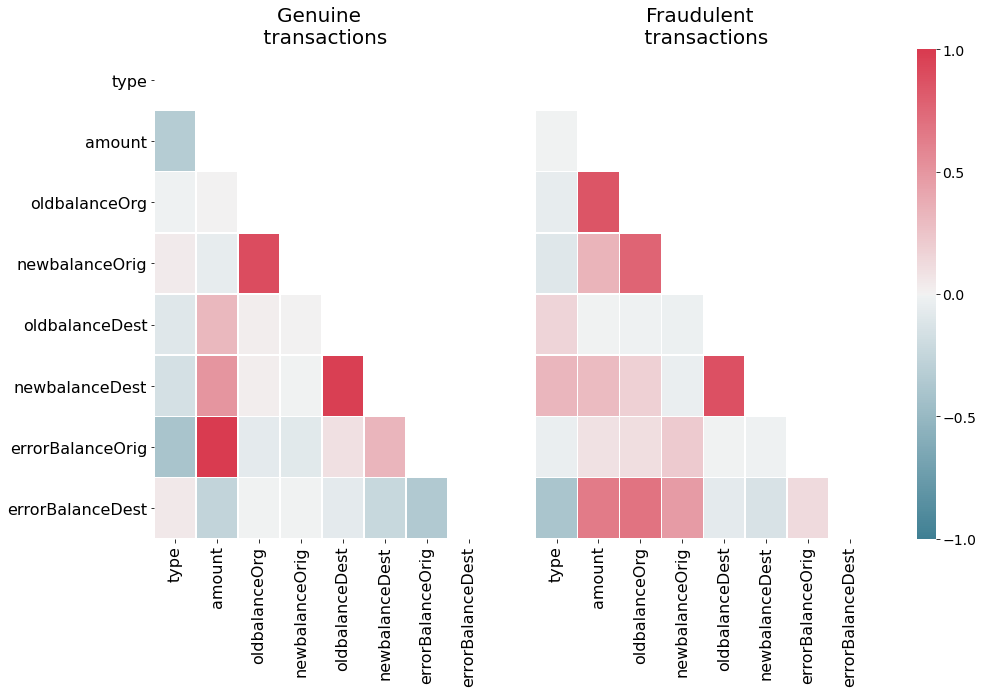

In [84]:
Xfraud = X.loc[Y == 1] # update Xfraud & XnonFraud with cleaned data
XnonFraud = X.loc[Y == 0]
                  
correlationNonFraud = XnonFraud.loc[:, X.columns != 'step'].corr()
mask = np.zeros_like(correlationNonFraud)
indices = np.triu_indices_from(correlationNonFraud)
mask[indices] = True

grid_kws = {"width_ratios": (.9, .9, .05), "wspace": 0.2}
f, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, gridspec_kw=grid_kws, \
                                     figsize = (14, 9))

cmap = sns.diverging_palette(220, 8, as_cmap=True)
ax1 =sns.heatmap(correlationNonFraud, ax = ax1, vmin = -1, vmax = 1, \
    cmap = cmap, square = False, linewidths = 0.5, mask = mask, cbar = False)
ax1.set_xticklabels(ax1.get_xticklabels(), size = 16); 
ax1.set_yticklabels(ax1.get_yticklabels(), size = 16); 
ax1.set_title('Genuine \n transactions', size = 20)

correlationFraud = Xfraud.loc[:, X.columns != 'step'].corr()
ax2 = sns.heatmap(correlationFraud, vmin = -1, vmax = 1, cmap = cmap, \
 ax = ax2, square = False, linewidths = 0.5, mask = mask, yticklabels = False, \
    cbar_ax = cbar_ax, cbar_kws={'orientation': 'vertical', \
                                 'ticks': [-1, -0.5, 0, 0.5, 1]})
ax2.set_xticklabels(ax2.get_xticklabels(), size = 16); 
ax2.set_title('Fraudulent \n transactions', size = 20);

cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), size = 14);

## Machine Learning to Detect Fraud in Skewed Data

#### 3. Demonstrate the performance of the model by using best set of tools. 

If there are too much skewness in the data, then many statistical model don't work but why. So in skewed data, the tail region may act as an outlier for the statistical model and we know that outliers adversely affect the model's performance especially regression-based models.

In [85]:
print('skew = {}'.format( len(Xfraud) / float(len(X)) ))

skew = 0.002964544224336551


Since the data is highly skewed, I use the area under the precision-recall curve (AUPRC) rather than the conventional area under the receiver operating characteristic (AUROC). This is because the AUPRC is more sensitive to differences between algorithms and their parameter settings rather than the AUROC (see Davis and Goadrich, 2006).

#### 4. Describe your model? 

Selection of ML algorithm: A first approach to deal with imbalanced data is to balance it by discarding the majority class before applying an ML algorithm. The disadvantage of undersampling is that a model trained in this way will not perform well on real-world skewed test data since almost all the information was discarded. A better approach might be to oversample the minority class, say by the synthetic minority oversampling technique (SMOTE) contained in the 'imblearn' library. Motivated by this, I tried a variety of anomaly-detection and supervised learning approaches

Finally, XGBoost, like several other ML algorithms, allows for weighting the positive class more compared to the negative class a setting that also allows to account for the skew in the data.

In [86]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, \
                                                random_state = randomState)

In [87]:
# Long computation in this cell (~1.8 minutes)
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights, \
                n_jobs = 4)
probabilities = clf.fit(trainX, trainY).predict_proba(testX)
print('AUPRC = {}'.format(average_precision_score(testY, \
                                              probabilities[:, 1])))

E:\Anaconda12\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:13:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUPRC = 0.9983642588456605


### The figure below shows that the new feature errorBalanceOrig that we created is the most relevant feature for the model. The features are ordered based on the number of samples affected by splits on those features.

In [ ]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(clf, height = 1, color = colours, grid = False,\
           show_values = False, importance_type = 'cover', ax = ax);

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);

###  Our fraud detection model which uses the decision tree Machine learning Algorithm can be understood using the following function.

In [ ]:
to_graphviz(clf)

The model we have learnt has a degree of bias and is slighly underfit. This is indicated by the levelling in AUPRC as the size of the training set is increased in the cross-validation curve below. 

The easiest way to improve the performance of the model still further is to increase the max_depth parameter of the XGBClassifier at the expense of the longer time spent learning the model. Other parameters of the classifier that can be adjusted to correct for the effect of the modest underfitting include decreasing min_child_weight and decreasing reg_lambda

In [ ]:
trainSizes, trainScores, crossValScores = learning_curve(\
XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4), trainX,\
                                         trainY, scoring = 'average_precision')

In [ ]:
trainScoresMean = np.mean(trainScores, axis=1)
trainScoresStd = np.std(trainScores, axis=1)
crossValScoresMean = np.mean(crossValScores, axis=1)
crossValScoresStd = np.std(crossValScores, axis=1)

colours = plt.cm.tab10(np.linspace(0, 1, 9))

fig = plt.figure(figsize = (14, 9))
plt.fill_between(trainSizes, trainScoresMean - trainScoresStd,
    trainScoresMean + trainScoresStd, alpha=0.1, color=colours[0])
plt.fill_between(trainSizes, crossValScoresMean - crossValScoresStd,
    crossValScoresMean + crossValScoresStd, alpha=0.1, color=colours[1])
plt.plot(trainSizes, trainScores.mean(axis = 1), 'o-', label = 'train', \
         color = colours[0])
plt.plot(trainSizes, crossValScores.mean(axis = 1), 'o-', label = 'cross-val', \
         color = colours[1])

ax = plt.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['train', 'cross-val'], bbox_to_anchor=(0.8, 0.15), \ins
               loc=2, borderaxespad=0, fontsize = 16);
plt.xlabel('training set size', size = 16); 
plt.ylabel('AUPRC', size = 16)
plt.title('Learning curves indicate slightly underfit model', size = 20);

### 5. What are the key factors that predict fraudulent customer? 

After our analysis work we can say that the customer name has nothing to do with the transaction. But , The amount present in the account before and after the transaction plays very important role in analysis work.

## 6. Do these factors make sense? If yes, How? If not, How not? 

After thoroughly interrogating the data at the outset to gain insight into which features could be discarded and those which could be valuably engineered. We already observed how other factors were not having any role in the transaction being decided as a fraud or not. As these factors were largely observed to be different in fraud and normal tranasaction they would help us very much to decide the transaction is valid or not.

### 7. What kind of prevention should be adopted while company update its infrastructure?

The plots provided visual confirmation that the data could be indeed be discriminated with the aid of the new features. To deal with the large skew in the data, we chose an appropriate metric and used an ML algorithm based on an ensemble of decision trees which works best with strongly imbalanced classes. The method used in this kernel should therefore be broadly applicable to a range of such problems. The company should not allow customer with abnormal transaction history to make larger transaction at once which will prevent such fraud transaction to greater extent.

### 8. Assuming these actions have been implemented, how would you determine if they work?

To determine if our actions work an post analysis work is required. Here we need to compare the number of fraud transactions pre and post the implementation of our new updates.